In this lab you will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function and optimizer
4. Train the network on the training data
5. Test the network on the test data

Using ``torchvision``, it’s extremely easy to load CIFAR10.



How to install a different version of a package

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

Use GPU if available

In [ ]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
   
The output of [torchvision datasets](https://pytorch.org/vision/stable/datasets.html#datasets) are PILImage images of range [0, 1].
We [transform](https://pytorch.org/vision/stable/transforms.html) them to normalized Tensors. Then we call the [dataloader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)



In [ ]:
# Define data transformation pipeline
transform = transforms.Compose([
    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize pixel values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Create data loader for training data with batch size 4 and shuffling
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create data loader for testing data with batch size 1 and shuffling
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True, num_workers=2)

# Define class labels for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


Let us [show](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib-pyplot-imshow) some of the training images


Train loader:
12500
{'frog': 5000, 'truck': 5000, 'deer': 5000, 'car': 5000, 'bird': 5000, 'horse': 5000, 'ship': 5000, 'cat': 5000, 'dog': 5000, 'plane': 5000}
torch.Size([4, 3, 32, 32])
cat ship car car

Test loader:
10000
{'cat': 1000, 'ship': 1000, 'plane': 1000, 'frog': 1000, 'car': 1000, 'truck': 1000, 'dog': 1000, 'horse': 1000, 'deer': 1000, 'bird': 1000}


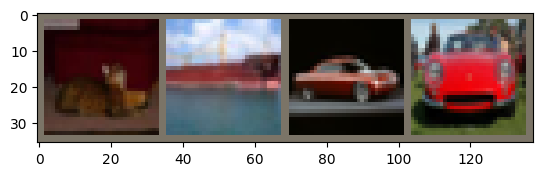

In [ ]:
import matplotlib.pyplot as plt  # Import library for plotting
import numpy as np  # Import library for numerical computations
from collections import Counter  # Import Counter for counting elements

# Function to display an image
def imshow(image):
    mean=torch.tensor([0.485, 0.456, 0.406])
    std=torch.tensor([0.229, 0.224, 0.225])

    # Unnormalize the image channels to [0, 1]
    image = image.mul(std.unsqueeze(1).unsqueeze(2))  # More efficient element-wise multiplication
    image = image.add(mean.unsqueeze(1).unsqueeze(2))  # Efficient element-wise addition

    image= image.clamp(0, 1)

    # Convert the tensor to a NumPy array
    npimg = image.numpy()
    # Plot the image using matplotlib
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # Transpose for correct display

# ------------------ Train Loader Section ------------------

print("Train loader:")

# Count the frequency of each class in the training set
stat = dict(Counter(trainset.targets))

# Create a new dictionary with class names as keys
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

# Print the length of the train loader (number of batches)
print(len(trainloader))

# Print the class distribution in the training set
print(new_stat)

# Get a batch of random training images and their labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Print the shape of the image tensor (batch_size, channels, height, width)
print(images.shape)

# Display the images using the imshow function
imshow(torchvision.utils.make_grid(images))

# Print the labels of the images
print(' '.join('%s' % classes[labels[j]] for j in range(4)))  # Print labels for 4 images

# ------------------ Test Loader Section ------------------

print("\nTest loader:")

# Similar steps for the test loader
stat = dict(Counter(testset.targets))
new_stat = stat.copy()
for k in stat.keys():
    new_stat[classes[k]] = stat[k]
    del new_stat[k]

print(len(testloader))
print(new_stat)


2. Define a Convolution Neural Network.
[network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    """
    This class defines a simple convolutional neural network (CNN) architecture
    for image classification.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer with 3 input channels (RGB),
                           6 output channels, and a kernel size of 5x5.
        pool (nn.MaxPool2d): Max pooling layer with a kernel size of 2x2.
        conv2 (nn.Conv2d): Second convolutional layer with 6 input channels
                           (from the first conv layer), 16 output channels,
                           and a kernel size of 5x5.
        fc1 (nn.Linear): First fully-connected layer that flattens the input
                         from the previous convolutional layers and has 120 neurons.
        fc2 (nn.Linear): Second fully-connected layer with 84 neurons.
        fc3 (nn.Linear): Output layer with 10 neurons, corresponding to the 10 classes
                         in CIFAR-10.

    Methods:
        forward(self, x): Defines the forward pass of the network.
    """

    def __init__(self):
        super(Net, self).__init__()  # Call the superclass constructor

        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.lrn = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2.0)
        self.conv1 = nn.Conv2d(3, 64,kernel_size=5,stride=2, padding=2)  # First convolutional layer
        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, padding=1)  # Second convolutional layer
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)  # Second convolutional layer
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)  # Second convolutional layer
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)  # Second convolutional layer
        self.fc1 = nn.Linear(256 * 2 * 2, 4096)  # First fully-connected layer
        self.fc2 = nn.Linear(4096, 4096) # Second fully-connected layer
        self.fc3 = nn.Linear(4096, 10)  # Output layer
        self.Drop = nn.Dropout(0.5)

    def forward(self, x):
        """
        Defines the forward pass of the neural network.

        Args:
            x (torch.Tensor): Input tensor representing the images.

        Returns:
            torch.Tensor: Output tensor representing the class probabilities.
        """

        x = self.pool(self.lrn(F.leaky_relu(self.conv1(x))))  # First convolutional layer with ReLU activation and pooling
        x = self.pool(self.lrn(F.leaky_relu(self.conv2(x))))  # Second convolutional layer with ReLU activation and pooling
        #x = self.pool(F.relu(self.conv1(x)))  # First convolutional layer with ReLU activation and pooling
        #x = self.pool(F.relu(self.conv2(x)))  # Second convolutional layer with ReLU activation and pooling

        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))
        #x = F.relu(self.conv3(x))
        #x = F.relu(self.conv4(x))

        x = self.pool(F.leaky_relu(self.conv5(x)))
        #x = self.pool(F.relu(self.conv5(x)))
        x = x.view(x.shape[0],-1)  # Flatten the output from convolutional layers
        # print(x.shape)
        x = F.leaky_relu(self.fc1(self.Drop(x)))  # First fully-connected layer with ReLU activation
        x = F.leaky_relu(self.fc2(self.Drop(x)))
        #x = F.relu(self.fc1(x))  # First fully-connected layer with ReLU activation
        #x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer
        return x

net = Net()
net.to(device)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lrn): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2.0)
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (conv2): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=10, bias=True)
  (Drop): Dropout(p=0.5, inplace=False)
)

Compute the receptive field of the network

In [ ]:
# This line attempts to clone a Git repository using a shell command.
#!git clone https://github.com/Fangyh09/pytorch-receptive-field.git

# This line would move the downloaded directory
#!mv -v pytorch-receptive-field/torch_receptive_field ./

# Import the 'receptive_field' function from the 'torch_receptive_field' library.
#from torch_receptive_field import receptive_field

# Calculate the receptive field of the network 'net' for an input image size of
# 3 channels (RGB) and 32x32 pixels. The 'receptive_field' function would analyze the network architecture and input size to determine
# the receptive field size for each layer and the overall network.
#receptive_field(net, input_size=(3, 32, 32))


3. Define a loss function and optimizer

Let's use a Classification [Cross-Entropy](https://pytorch.org/docs/stable/nn.html#loss-functions) loss and [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD) with momentum.



In [ ]:
import torch.optim as optim  # Import the optim module from PyTorch for optimization algorithms

# Define the loss function
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for multi-class classification

# Define the optimizer
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.001)
schedular = optim.lr_scheduler.StepLR(optimizer, step_size =2, gamma=0.8)
# Explanation of the optimizer:
#   - optim.SGD(net.parameters(), lr=0.001, momentum=0.9):
#       - optim.SGD: This selects the Stochastic Gradient Descent (SGD) optimizer.
#       - net.parameters(): This provides the parameters of the network (`net`) to be optimized.
#       - lr=0.001: This sets the learning rate to 0.001 (controls how much the weights are updated).
#       - momentum=0.9: This sets the momentum to 0.9 (a technique to improve convergence).


4. Train the network on the training data


We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
num_print_intervals = 4 # Number of times to print statistics

num_print_intervals+=1
print_interval = int(len(trainloader) / num_print_intervals)

n_epochs=20
net.train()############################################################
epoch_losses = []

# Loop over the dataset multiple times (2 epochs in this case)
for epoch in range(n_epochs):
    running_loss=[]  # Initialize a variable to track the total loss for this epoch
    batch_losses = []

    # Iterate over the training data loader
    for i, data in enumerate(trainloader, 0):
        # Get the inputs (images) and labels from the current batch
        inputs, labels = data

        # Move the inputs and labels to the specified device (CPU or GPU)
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Clear the gradients accumulated in the previous iteration
        optimizer.zero_grad()

        # Training loop: forward pass, backward pass, and optimization
        # 1. Forward pass:
        outputs = net(inputs)  # Pass the input images through the network to get predictions (outputs)
        # 2. Calculate loss:
        loss = criterion(outputs, labels)  # Compute the loss based on the predictions (outputs) and ground truth labels
        # 3. Backward pass:
        loss.backward()  # Backpropagate the loss to calculate gradients for each parameter in the network
        # 4. Optimization step:
        optimizer.step()  # Update the weights and biases of the network based on the calculated gradients

        running_loss.append(loss.item())  # Accumulate the loss for this mini-batch
        batch_losses.append(loss.item())

        if i>0 and i % print_interval == 0:  # Check batch interval
            # Print the average loss for the mini-batches
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, np.mean(running_loss)))
            # Reset the running loss for the next interval
            running_loss=[]
    schedular.step()
    epoch_losses.append(np.mean(running_loss))

# Training complete
print('Finished Training')


[1,  2501] loss: 2.3028
[1,  5001] loss: 2.2219
[1,  7501] loss: 1.9852
[1, 10001] loss: 1.8227
[2,  2501] loss: 1.6172
[2,  5001] loss: 1.5144
[2,  7501] loss: 1.4482
[2, 10001] loss: 1.3530
[3,  2501] loss: 1.1693
[3,  5001] loss: 1.1328
[3,  7501] loss: 1.0951
[3, 10001] loss: 1.0642
[4,  2501] loss: 0.9406
[4,  5001] loss: 0.9203
[4,  7501] loss: 0.9070
[4, 10001] loss: 0.9061
[5,  2501] loss: 0.7322
[5,  5001] loss: 0.7358
[5,  7501] loss: 0.7337
[5, 10001] loss: 0.7332
[6,  2501] loss: 0.6143
[6,  5001] loss: 0.6165
[6,  7501] loss: 0.6279
[6, 10001] loss: 0.6308
[7,  2501] loss: 0.4681
[7,  5001] loss: 0.4840
[7,  7501] loss: 0.4838
[7, 10001] loss: 0.5015
[8,  2501] loss: 0.3798
[8,  5001] loss: 0.3919
[8,  7501] loss: 0.4083
[8, 10001] loss: 0.4105
[9,  2501] loss: 0.2557
[9,  5001] loss: 0.2598
[9,  7501] loss: 0.2884
[9, 10001] loss: 0.3037
[10,  2501] loss: 0.1965
[10,  5001] loss: 0.2140
[10,  7501] loss: 0.2307
[10, 10001] loss: 0.2319
[11,  2501] loss: 0.1296
[11,  5001]

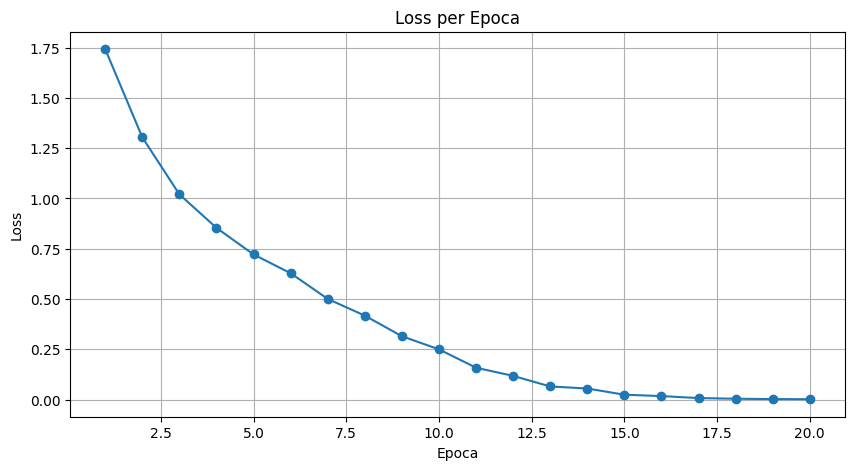

In [ ]:
# Plotting delle loss dopo l'addestramento
plt.figure(figsize=(10, 5))
plt.plot(range(1, n_epochs + 1), epoch_losses, marker='o')
plt.title('Loss per Epoca')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

5. Test the network on the test data


We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

In [ ]:
# Initialize variables to track accuracy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
correct = 0
total = 0
all_preds = []
all_labels = []
net.eval()#####################################################################
# Disable gradient calculation for better performance during evaluation
with torch.no_grad():
    # Loop over the test loader
    for data in testloader:
        # Get the image and label from the current batch
        image, label = data

        # Move the image data to the specified device (CPU or GPU)
        image = image.to(device)

        # Get the network's prediction for the image
        output = net(image)
        # smax = torch.nn.Softmax(dim=1)(output.cpu())

        # Find the class with the highest probability
        _, predicted = torch.max(output.cpu(), 1)  # Equivalent to pred = torch.argmax(output.cpu(), dim=1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(label.cpu().numpy())
        # Update total number of test images
        total += label.size(0)  # label.size(0) gives the batch size

        # Count correct predictions
        correct += (predicted == label).sum().item()  # Count true positives
# Calculate and print accuracy
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))


#cm = confusion_matrix(all_labels, all_preds)
#plt.figure(figsize=(10, 10))
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
#plt.xlabel('Predicted')
#plt.ylabel('True')
#plt.title('Confusion Matrix')
#plt.show()


Accuracy of the network on the 10000 test images: 78 %


**!HOMEWORK!**

This homework assignment asks you to performs 2 tasks:

1. Analyze Results with Different Network Parameters:

This involves training the network with various configurations of network parameters and analyzing the impact on performance. Here's a step-by-step approach:

**Choose Network Parameters:**

Select the network parameters you want to experiment with. Common choices include:

Number of layers: You can try increasing or decreasing the number of layers in your chosen network architecture (e.g., convolutional layers in a CNN).
Learning rate: Experiment with different learning rates (e.g., 0.01, 0.001, 0.0001) to find a balance between fast learning and stability.
Other parameters: Depending on your network architecture, there might be additional options like:
Number of filters in convolutional layers: This affects the complexity of features extracted from the data.
Activation functions: Experiment with different activation functions (e.g., ReLU, Leaky ReLU) to introduce non-linearity.
Optimizer parameters: Some optimizers (e.g., Adam) have hyperparameters you can adjust.
Train the network for a different number of epochs.

**Analyze Results:**

Compare the performance of the network across different parameter configurations:

How accuracy/loss changes with different parameter values.
2. Show and Explain Errors of the Best Network:

Once you identify the **best performing network configuration** (based on metrics like accuracy or loss), analyze its errors.
For example you can generate a confusion matrix. This matrix visualizes how often the network predicted each class correctly or incorrectly.

Useful resources:
*   [network layers](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [activation function](https://pytorch.org/docs/stable/nn.html#convolution-layers)
*   [loss functions](https://pytorch.org/docs/stable/nn.html#convolution-layers)



